## Table of content

| Chapter                                      | Description |
|:---------------------------------------------|:------------|
| Main goal                                    |             |
| Data description                             |             |
| Statistic                                    |             |
| Plots                                        |             |
| Pattern selection                            |             |
| Preprocessing and feature engineering        |             |
| Potential issues                             |             |
| Manual prediction                            |             |
| Conclusion                                   |             |

## Main goal

The main goal of this notebook is get data understanding, select patterns in the data, overthink preprocessing process and feature engineering, select potential problems and do manual prediction of the data.

## Data description

This dataset provides historical sales data for an e-commerce platform in Russia. It consists of five files containing information on items, categories, shops, and sales transactions from January 2013 to October 2015.

### File Descriptions:

`items.csv`

* `item_name`: `string` - Name of the good.
* `item_id`: `integer` - Primary key, a unique identifier for each item.
* `item_category_id`: `integer` - Foreign key linking to item_categories.csv.

`item_categories.csv`

* `item_category_name`: `string` - Name of the product category.
* `item_category_id`: `integer` - Primary key, a unique identifier for each category.

`shops.csv`

* `shop_name`: `string` - Name of the shop.
* `shop_id`: `integer` - Primary key, a unique identifier for each shop.

`sales_train.csv`

* `date`: `datetime` - Date of purchase in dd.mm.yyyy format.
* `date_block_num`: `integer` - A unique monthly identifier. January 2013 is 0, February 2013 is 1, and so on.
* `shop_id`: `integer` - Foreign key linking to shops.csv.
* `item_id`: `integer` - Foreign key linking to items.csv.
* `item_price`: `float` - The price of the item in Russian Rubles (RUB).
* `item_cnt_day`: `integer` - The number of units of the item sold on a specific day. This value can be negative due to returns.

In [45]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df_train = pd.read_csv('data/sales_train.csv')

In [4]:
df_train.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')

## Statistic

In this chapter we'll look at some statistic measures like math moments. It will help us to select some issues in the data.

As we can see below, data has very "heavy" right tail, the max value of "item_cnt_day" field is 2169, but i the same time mean and standard deviation are 1.242 and 2.618. Skewness and kurtosis also confirm my observations. And it's a common situation for finance dataset.

In [17]:
df_train[["item_cnt_day", "item_price"]].describe()

,item_cnt_day,item_price
count,2.935849e+06,2.935849e+06
mean,1.242641e+00,8.908532e+02
std,2.618834e+00,1.729800e+03
min,-2.200000e+01,-1.000000e+00
25%,1.000000e+00,2.490000e+02
50%,1.000000e+00,3.990000e+02
75%,1.000000e+00,9.990000e+02
max,2.169000e+03,3.079800e+05


In [8]:
print(f"Skewness: {df_train['item_cnt_day'].skew()}")
print(f"Kurtosis: {df_train['item_cnt_day'].kurt()}")

Skewness: 272.83316168440535
Kurtosis: 177478.0987736997


## Plots

Plots help us to see data's distribution, select different patterns in data, and select potential outliers.

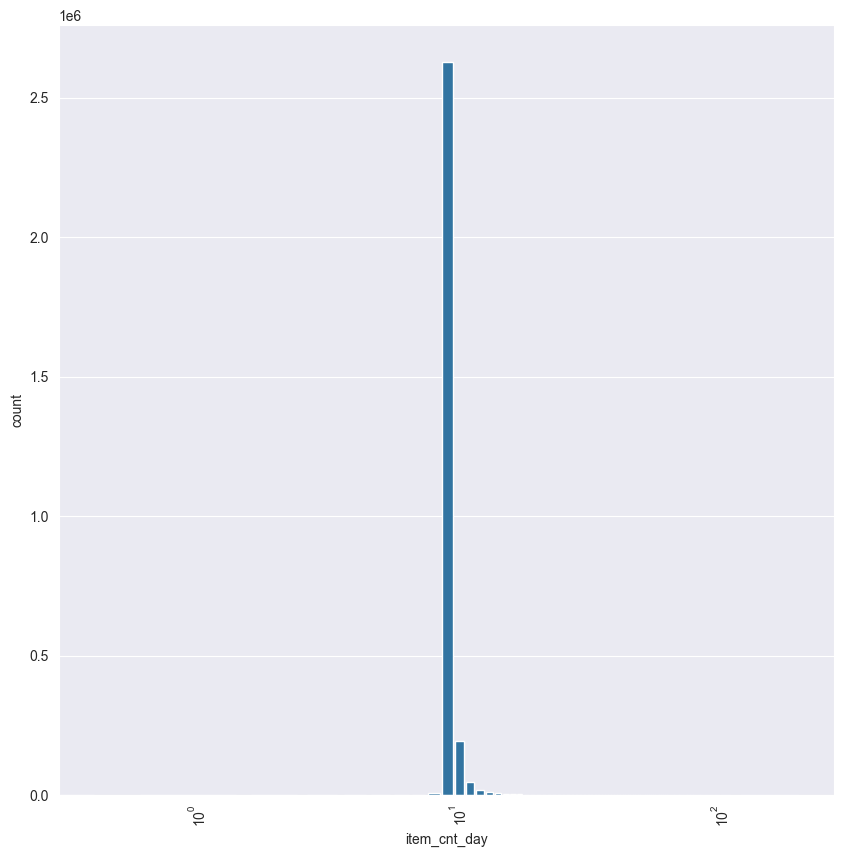

In [10]:
plt.figure(figsize=(10,10))
sns.barplot(x="item_cnt_day", y="count", data=df_train["item_cnt_day"].value_counts().reset_index())
plt.xticks(rotation=90)
plt.xscale("log")
plt.show()

    date_block_num  item_cnt_day
0                0      131479.0
1                1      128090.0
2                2      147142.0
3                3      107190.0
4                4      106970.0
5                5      125381.0
6                6      116966.0
7                7      125291.0
8                8      133332.0
9                9      127541.0
10              10      130009.0
11              11      183342.0
12              12      116899.0
13              13      109687.0
14              14      115297.0
15              15       96556.0
16              16       97790.0
17              17       97429.0
18              18       91280.0
19              19      102721.0
20              20       99208.0
21              21      107422.0
22              22      117845.0
23              23      168755.0
24              24      110971.0
25              25       84198.0
26              26       82014.0
27              27       77827.0
28              28       72295.0
29        

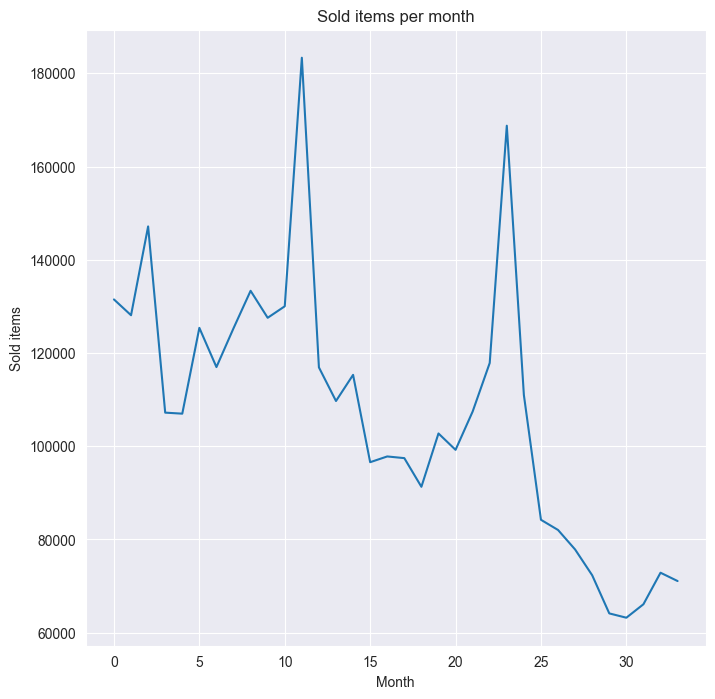

In [37]:
monthly_sales = df_train.groupby(["date_block_num"])["item_cnt_day"].sum().reset_index()
plt.figure(figsize=(8,8))
plt.title("Sold items per month")
plt.xlabel("Month")
plt.ylabel("Sold items")
sns.lineplot(data=monthly_sales, x="date_block_num", y="item_cnt_day")
plt.show()

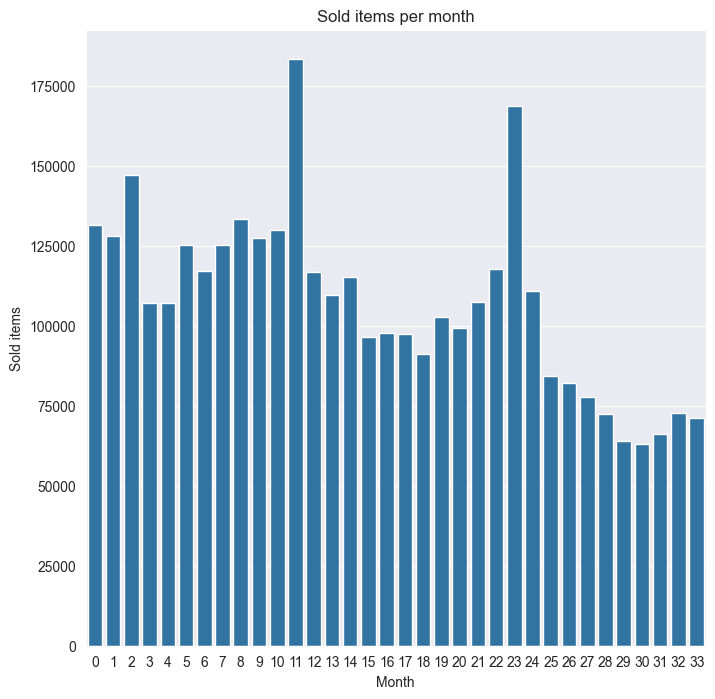

In [14]:
plt.figure(figsize=(8,8))
plt.title("Sold items per month")
plt.xlabel("Month")
plt.ylabel("Sold items")
sns.barplot(data=monthly_sales, x="date_block_num", y="item_cnt_day")
plt.show()

### Trend, Seasonality, Irregular

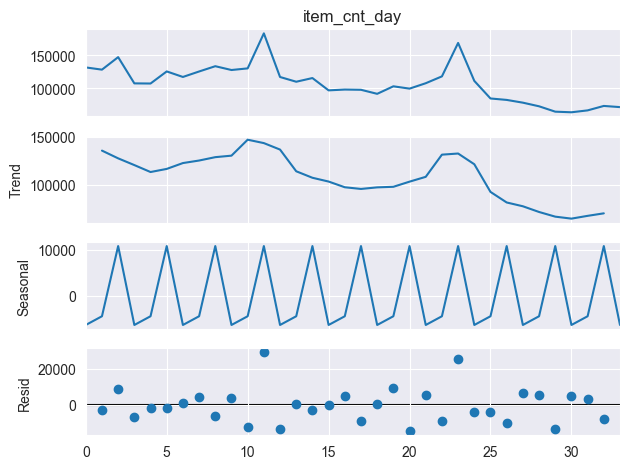

In [63]:
data_for_decomposition = pd.Series(monthly_sales["item_cnt_day"], index=monthly_sales["date_block_num"])
decomposition = seasonal_decompose(data_for_decomposition, model="add", period=3)
decomposition.plot()
plt.show()

## Pattern selection

Data has 22170 different products, and in my point of view it's impossible to build 22k separated models. So i want to build a single model for amount predicting. It's time series predicting task, so time series components selecting is useful analyzing tool. As we can se plots shows downtrend, permanent seasonability and little irregular. it's a good news, because we can use models like SARIMA to predict monthly sales. But we need some mechanism to divide this sum into amount of products.

## Preprocessing and feature engineering

It's a common case to take log from price feature, it helps to make distribution more symmetric, make distribution mode linear and other. Outliers also common case in finance data, so I shouldn't drop them and try to understand its nature, for example black fridays or something like that. For products that didn't have sales in a month, value must be set to 0. Shops are linked with items (products), It's clear to add some information about shops like popularity or rating.

## Potential issues

As I described above, data has 22170 products, and it's impossible to build model for every product. Instead of it we can build one general model that can predict monthly sales over all products and then this sum will decompose into products via another model. Outliers, we cannot to drop it, because it's common case in finance data, Instead of it we must find out its nature, for example holidays, sales, and other reasons.